In [1]:
import os
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})

In [2]:
path = os.getcwd().strip('Bayes')+'Fetch Data/datasets/'

df = pd.read_csv(path+'pitchSpeed_spinRate.csv')
print(df.shape)

df.head()

(1910986, 3)


,endSpeed,spinRate,pitchType
0,87.7,1926.0,Four-Seam Fastball
1,89.0,1872.0,Four-Seam Fastball
2,83.9,1661.0,Changeup
3,88.3,1934.0,Two-Seam Fastball
4,88.9,1997.0,Four-Seam Fastball


In [3]:
df.dropna(inplace=True)

In [4]:
# drop outlier pitch types
pitchTypes_toDrop = ['Automatic Ball','Pitchout','Eephus']

i = df[df['pitchType'].isin(pitchTypes_toDrop)].index
df.drop(index=i,inplace=True)

# # drop outlier pitch speeds
# i = df[df['endSpeed']<df['endSpeed'].quantile(.001)].index
# df.drop(index=i,inplace=True)

In [5]:
df.shape

(1848002, 3)

### Check for Normality

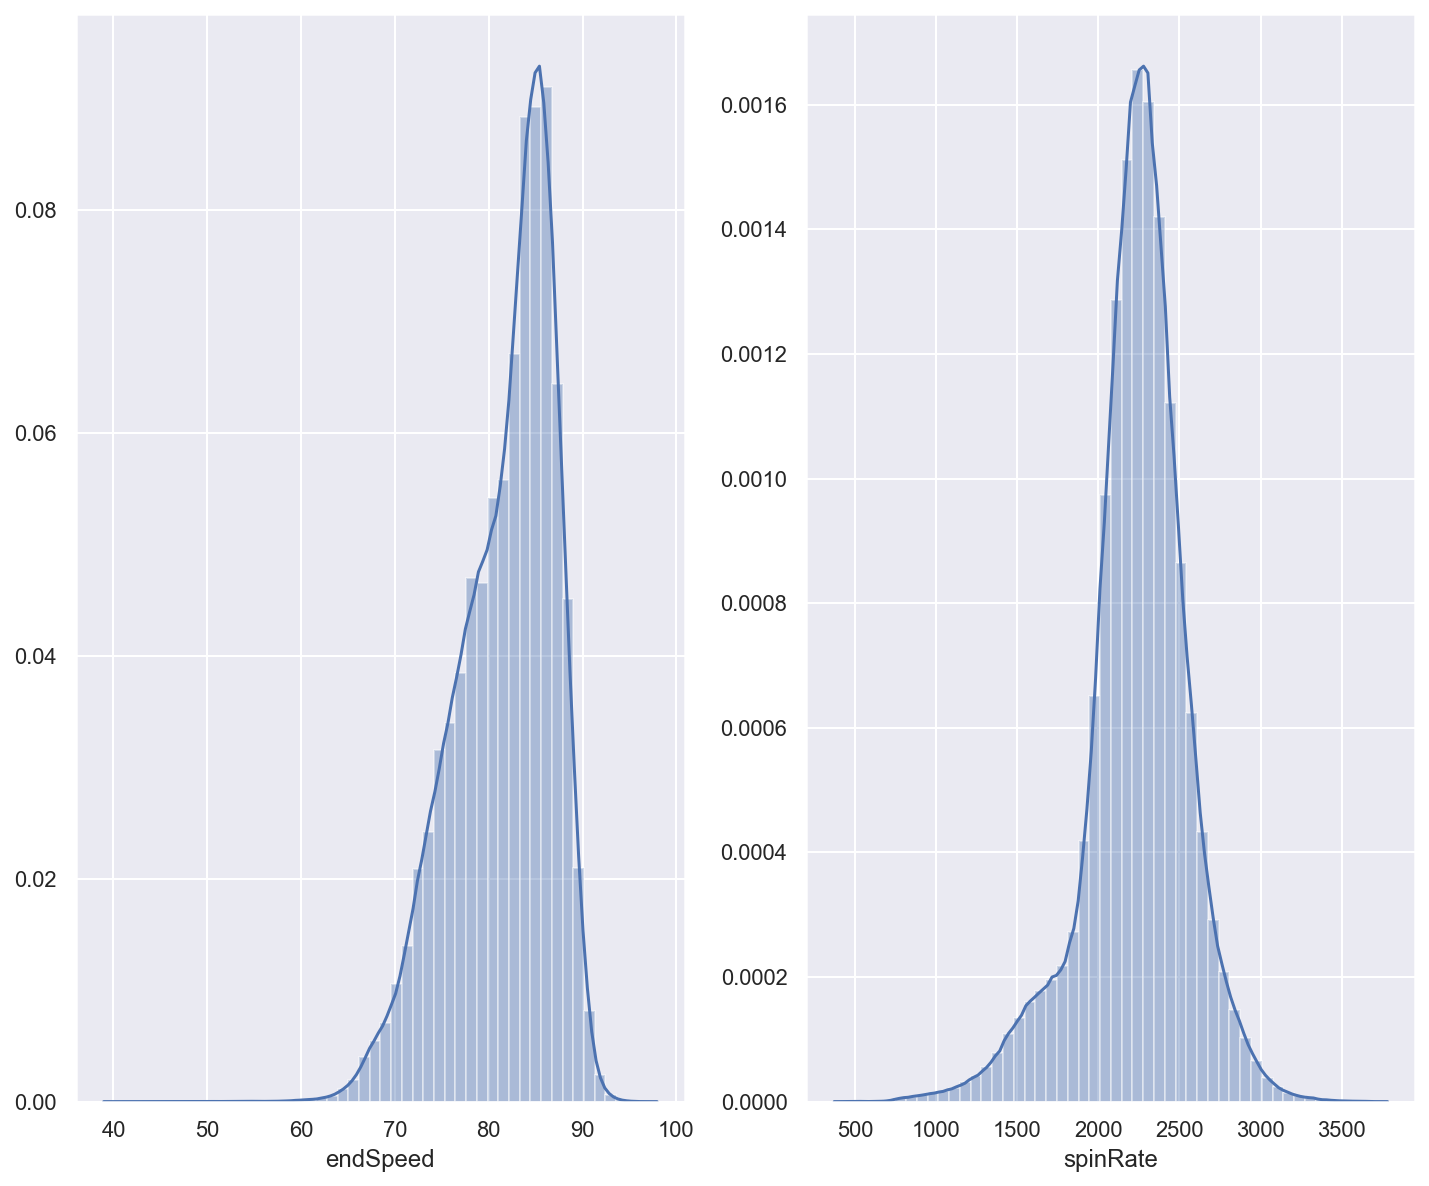

In [6]:
f, axes = plt.subplots(1,2)
sns.distplot(df['endSpeed'],ax=axes[0])
sns.distplot(df['spinRate'],ax=axes[1])

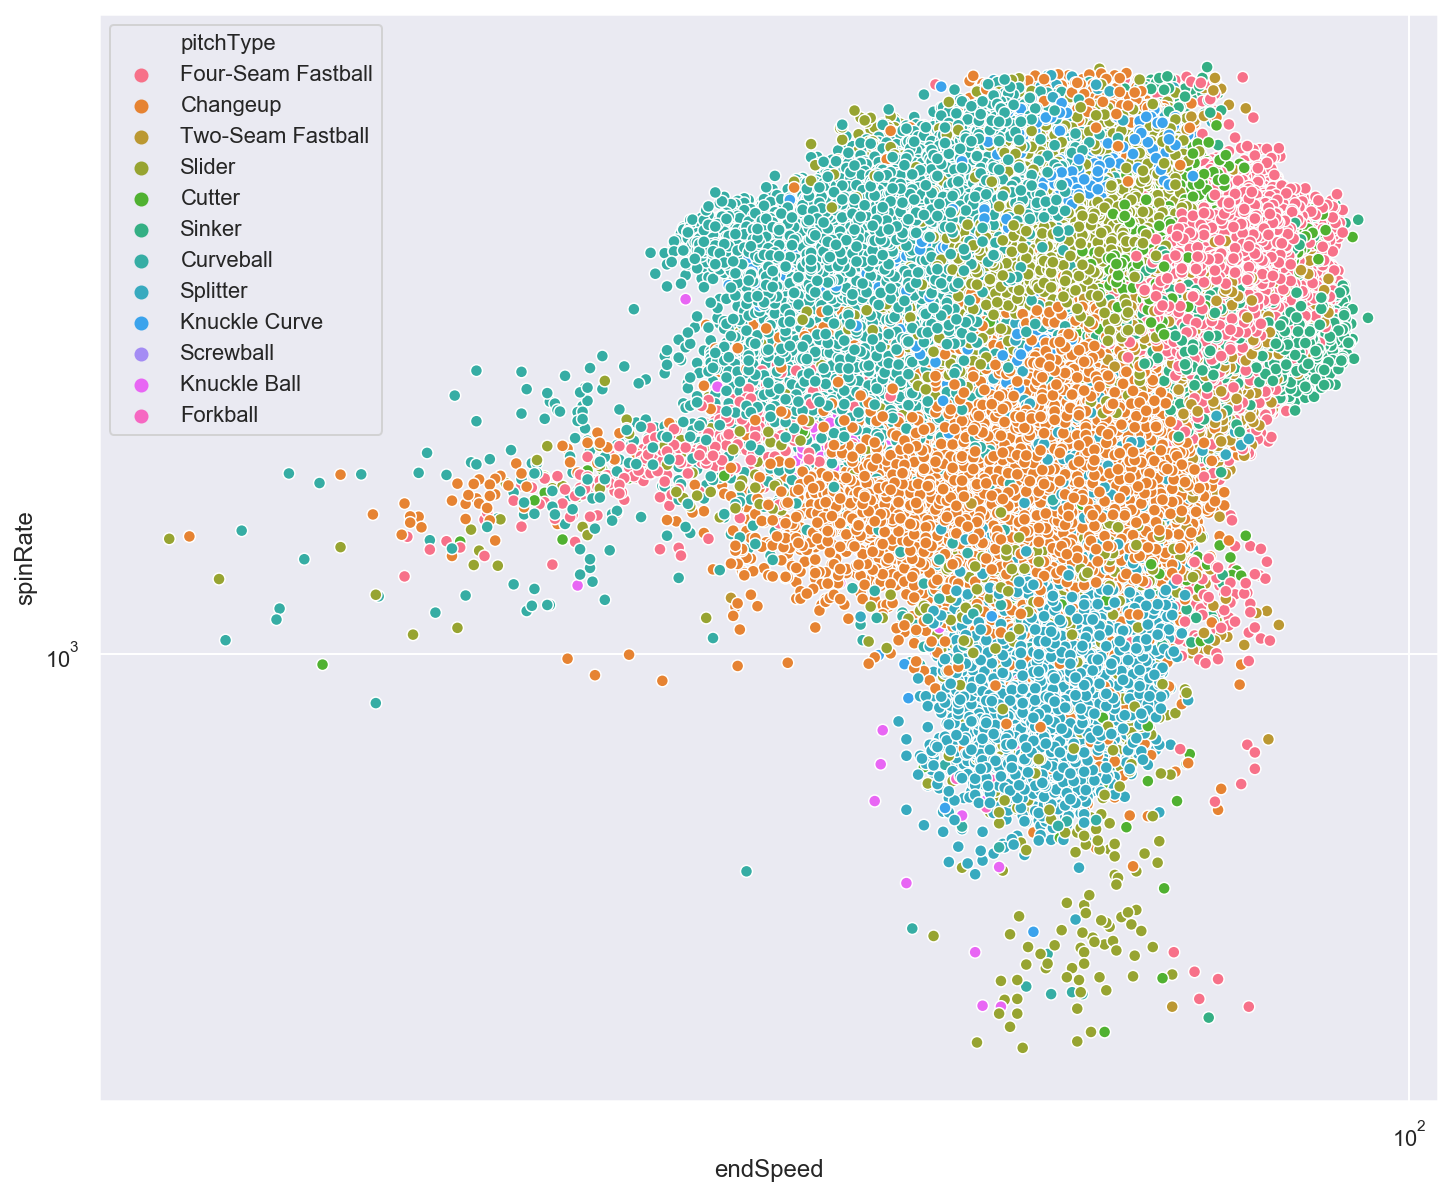

In [7]:
fig, ax = plt.subplots()
ax.set(xscale='symlog',yscale='symlog')
sns.scatterplot(x=df['endSpeed'],y=df['spinRate'],hue=df['pitchType'])

#### Build a Bayes Classifier with Numpy
- A 'fit' method needs to calculate prior and postierior probabilities for each column/class. 
- Let's start with 'fastball' and 'not fastball' to make life easier

In [8]:
def is_fastball(x):
    if 'Fastball' in x['pitchType']:
        return 'fastball'
    else:
        return 'not fastball'
df['is_fastball'] = df.apply(lambda x: is_fastball(x),axis=1)
df['is_fastball'].value_counts()

not fastball    974122
fastball        873880
Name: is_fastball, dtype: int64

In [9]:
# Create a function that calculates p(x | y):
def likelihood(x,mean,sigma):
    return np.exp(-(x-mean)**2/(2*sigma**2))*(1/(np.sqrt(2*np.pi)*sigma))

In [10]:
def fit(X,Y):
    # calculate priors 
    num_samples = X.shape[0]
    classes = np.unique(Y)
    priors = {G:len(np.where(Y==G)[0])/len(Y) for G in classes}

    num_classes = len(np.unique(Y))
    num_predictors = X.shape[1]
    num_records = X.shape[0]
    out = np.empty((num_classes,num_predictors,num_records),dtype=[('value','f4'),('class_value','S20')])
    
    params = {}
    for G in classes:
        class_params = []
        for i in range(num_predictors):
            feature_params = {}
            feature_params['prior'] = len(np.where(Y==G)[0])/len(Y)
            feature_params["mean"] = X[np.where(Y==G)][:,i].mean()
            feature_params["sigma"] = X[np.where(Y==G)][:,i].std()
            
            class_params.append(feature_params)
        params[G]=class_params
    
    def predict(X_test):
        class_probabilites = {}
        for G in classes:
            liklihoods = np.empty(X_test.shape)
            for i in range(liklihoods.shape[1]):
                liklihoods[:,i] = likelihood(x[:,i],params[G][i]['mean'],params[G][i]['sigma'])
            out = np.prod(liklihoods,axis=1)
            out*=params[G][0]['prior']
            class_probabilites[G]=out
        return class_probabilites
                
    return predict
        
    
        

In [11]:
y = df['is_fastball'].to_numpy()
x = df[['endSpeed','spinRate']].to_numpy()
nb = fit(x,y)
predict = nb(x)

In [12]:
predict['fastball']>predict['not fastball']

array([ True,  True, False, ...,  True,  True,  True])

In [13]:
fastballs = predict['fastball']==np.max(np.vstack([predict['fastball'],predict['not fastball']]).T,axis=1)

In [20]:
from sklearn.metrics import classification_report

In [28]:
pd.DataFrame(classification_report(y == "fastball",fastballs,output_dict=True))

,False,True,accuracy,macro avg,weighted avg
precision,0.921015,0.793438,0.850679,8.572267e-01,8.606868e-01
recall,0.783955,0.925057,0.850679,8.545062e-01,8.506793e-01
f1-score,0.846976,0.854207,0.850679,8.505918e-01,8.503957e-01
support,974122.000000,873880.000000,0.850679,1.848002e+06,1.848002e+06
